In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import os
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torchvision.transforms import ToTensor

from sklearn.neighbors import KNeighborsClassifier
import sklearn
from sklearn.metrics import confusion_matrix

import pretrainedmodels

from utils import AllTripletSelector,\
                  HardestNegativeTripletSelector,\
                  RandomNegativeTripletSelector,\
                  SemihardNegativeTripletSelector


cuda = torch.cuda.is_available()
%matplotlib inline

In [2]:
global_seed = 29
np.random.seed(global_seed)
torch.manual_seed(global_seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed(global_seed)
    torch.cuda.manual_seed_all(global_seed)

In [3]:
all_losses = {'train': [], 'val': []}

In [4]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    print('Триплет лосс (реализация из pytorch)')
    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)    
        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)
        
        all_losses['train'].append(train_loss)
        all_losses['val'].append(val_loss)
        
        message = 'Эпоха: {}/{}. '.format(epoch + 1, n_epochs)
        message += 'Тренировочное множество: {:.4f} Валидационное множество: {:.4f}'.format(train_loss, val_loss)
        
#         for metric in metrics:
#             message += '\t{}: {}'.format(metric.name(), metric.value())
#         for metric in metrics:
#             message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
#         print(loss_outputs.item())
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())
####################################
#             print(message)
####################################
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
class OnlineTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()
            
        # Вызывать с параметрами (a, p, n)
        triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2.0, reduction='none')
        # a p n
        a = embeddings[triplets[:, 0]]
        p = embeddings[triplets[:, 1]]
        n = embeddings[triplets[:, 2]]
        
        losses = triplet_loss(a, p, n) #print(losses.shape)
        
        return losses.mean(), len(triplets)

In [6]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size)
        self.convnet = models.resnet101(pretrained=True)
        num_ftrs = self.convnet.fc.in_features
        print('Размерность вектора на выходе свёрточной части сети: ' + str(num_ftrs))
        
        self.convnet.fc = nn.Sequential(nn.Linear(num_ftrs, 128),
                                        nn.Tanh()
                                        )
        
        for param in self.convnet.parameters():
            param.requires_grad = False
        for param in self.convnet.layer4[0].parameters():
            param.requires_grad = True
        for param in self.convnet.layer4[1].parameters():
            param.requires_grad = True
        for param in self.convnet.layer4[2].parameters():
            param.requires_grad = True
        for param in self.convnet.avgpool.parameters():
            param.requires_grad = True
        for param in self.convnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.convnet(x) # 4x2

    def get_embedding(self, x):
        return self.forward(x)
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [7]:
class SimpleDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transforms = self.dataset.transform
        self.imgs_info = self.dataset.imgs
        self.labels = [x[1] for x in self.imgs_info]
        
    def get_image_by_index(self, index):
        path = self.imgs_info[index][0]
        img = Image.open(path).convert('RGB')

        return img

    def __getitem__(self, index):
        label = self.labels[index]
        img = self.get_image_by_index(index)
        img = self.transforms(img)

        return img, label

    def __len__(self):
        return len(self.imgs_info)

In [8]:
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples):
        self.dataset = dataset
        self.imgs_info = self.dataset.imgs
        self.labels = [x[1] for x in self.imgs_info]
        self.labels_set = set(list(self.dataset.class_to_idx.values()))
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                     for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(list(self.labels_set), self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [9]:
mean, std = 0.5, 0.5

def train_aug():
    return transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

def test_aug():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

In [10]:
data_dir = './artists-prepared/'

In [11]:
batch_size = 256
kwargs = {'num_workers': 6, 'pin_memory': True} if cuda else {}

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_aug())
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), test_aug())
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_aug())

simple_train_dataset = SimpleDataset(train_dataset)
simple_val_dataset   = SimpleDataset(val_dataset)
simple_test_dataset  = SimpleDataset(test_dataset)

simple_train_loader = torch.utils.data.DataLoader(simple_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
simple_val_loader   = torch.utils.data.DataLoader(simple_val_dataset, batch_size=batch_size, shuffle=True, **kwargs)
simple_test_loader  = torch.utils.data.DataLoader(simple_test_dataset, batch_size=batch_size, shuffle=True, **kwargs)

train_batch_sampler = BalancedBatchSampler(dataset=train_dataset, n_classes=8, n_samples=16)
val_batch_sampler   = BalancedBatchSampler(dataset=val_dataset, n_classes=8, n_samples=16)

online_train_loader = torch.utils.data.DataLoader(simple_train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_val_loader   = torch.utils.data.DataLoader(simple_val_dataset, batch_sampler=val_batch_sampler, **kwargs)

In [12]:
margin = 1.
model = EmbeddingNet()
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, AllTripletSelector())
lr = 5*1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.2)
n_epochs = 30
log_interval = 10000

Размерность вектора на выходе свёрточной части сети: 2048


In [13]:
# model.load_state_dict(torch.load('059.pth'))

In [14]:
%%time
fit(online_train_loader, online_val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Триплет лосс (реализация из pytorch)
Эпоха: 1/30. Тренировочное множество: 0.5763 Валидационное множество: 0.3571
Эпоха: 2/30. Тренировочное множество: 0.4053 Валидационное множество: 0.3398
Эпоха: 3/30. Тренировочное множество: 0.3643 Валидационное множество: 0.3009
Эпоха: 4/30. Тренировочное множество: 0.3254 Валидационное множество: 0.2794
Эпоха: 5/30. Тренировочное множество: 0.2792 Валидационное множество: 0.2749
Эпоха: 6/30. Тренировочное множество: 0.2604 Валидационное множество: 0.2355
Эпоха: 7/30. Тренировочное множество: 0.2246 Валидационное множество: 0.2489
Эпоха: 8/30. Тренировочное множество: 0.2233 Валидационное множество: 0.2768
Эпоха: 9/30. Тренировочное множество: 0.1982 Валидационное множество: 0.2517
Эпоха: 10/30. Тренировочное множество: 0.1930 Валидационное множество: 0.2427
Эпоха: 11/30. Тренировочное множество: 0.1677 Валидационное множество: 0.1971
Эпоха: 12/30. Тренировочное множество: 0.1482 Валидационное множество: 0.1864
Эпоха: 13/30. Тренировочное множеств

In [15]:
torch.save(model.state_dict(), '059.pth')

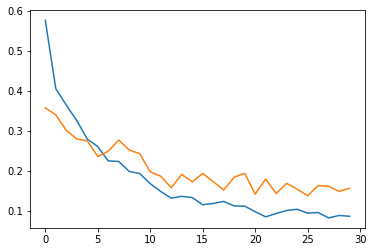

In [16]:
plt.plot(all_losses['train'][0:])
plt.plot(all_losses['val'][0:])

In [17]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 128))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [18]:
# numpy.ndarray
train_embeddings, train_labels = extract_embeddings(simple_train_loader, model)
val_embeddings, val_labels     = extract_embeddings(simple_val_loader, model)
test_embeddings, test_labels   = extract_embeddings(simple_test_loader, model)

In [19]:
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

7136
1823
27


In [21]:
knn_model = KNeighborsClassifier(n_neighbors=40)
knn_model.fit(train_embeddings, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=40, p=2,
           weights='uniform')

In [22]:
predicted_val = knn_model.predict(val_embeddings)
sklearn.metrics.accuracy_score(val_labels, predicted_val, normalize=True, sample_weight=None)

0.7334064728469556

Confusion matrix, without normalization


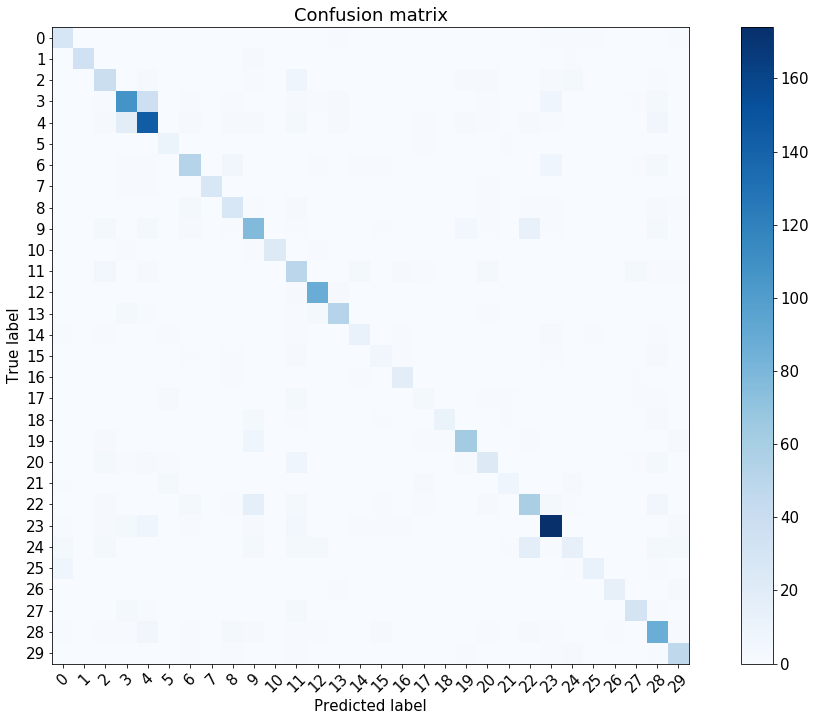

In [24]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(val_labels, predicted_val)
plt.figure(figsize=(15, 10))
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(0, 30)], title='Confusion matrix')
plt.show()

## Применяем подход к тестовому множеству

In [25]:
test_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
test_labels_changed = [31 if 0==x else 999 for x in test_labels]
test_labels_changed

[31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31]

In [61]:
train_and_val_labels = np.append(train_labels, val_labels)
train_val_test_labels = np.append(train_and_val_labels, test_labels_changed[0:17])
np.unique(train_val_test_labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31.])

In [62]:
train_and_val_embeddings  = np.append(train_embeddings, val_embeddings,0)
train_val_test_embeddings = np.append(train_and_val_embeddings, test_embeddings[0:17],0)
train_val_test_embeddings

array([[ 0.79582614,  0.96188056, -0.80844522, ..., -0.68490559,
         0.97080493, -0.85099959],
       [ 0.98309296,  0.98517531,  0.18030128, ..., -0.83475673,
         0.98855466, -0.96835673],
       [ 0.77342772,  0.96110833, -0.9703384 , ..., -0.85027468,
         0.97544253, -0.92909449],
       ...,
       [ 0.93896079,  0.99211562, -0.64723146, ..., -0.85090059,
         0.97309756, -0.82820147],
       [ 0.97429407,  0.99792302, -0.22154392, ..., -0.95297611,
         0.98886496, -0.92894441],
       [ 0.95690864,  0.99797946, -0.52380472, ..., -0.93178529,
         0.99174106, -0.93266588]])

In [63]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(train_val_test_embeddings, train_val_test_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [64]:
predicted_test = knn_model.predict(test_embeddings[17:])
sklearn.metrics.f1_score(test_labels_changed[17:], predicted_test, average='micro')

0.5

In [65]:
predicted_test

array([31., 24., 22., 31., 31., 31., 24., 24., 22., 31.])